In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import gymnasium as gym

In [4]:

# 1. Implement Ornstein-Uhlenbeck Noise for better exploration in physical tasks
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula: x_t = x_{t-1} + theta * (mean - x_{t-1}) * dt + std * sqrt(dt) * noise
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

# 2. Replay Buffer (Optimized)
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)): # Reduced size for memory
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim), dtype=np.float32)
        self.action = np.zeros((max_size, action_dim), dtype=np.float32)
        self.next_state = np.zeros((max_size, state_dim), dtype=np.float32)
        self.reward = np.zeros((max_size, 1), dtype=np.float32)
        self.done = np.zeros((max_size, 1), dtype=np.float32)

    def store(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.done[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=64):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            tf.convert_to_tensor(self.state[idx]),
            tf.convert_to_tensor(self.action[idx]),
            tf.convert_to_tensor(self.reward[idx]),
            tf.convert_to_tensor(self.next_state[idx]),
            tf.convert_to_tensor(self.done[idx])
        )

# 3. Networks (Functional API is often cleaner for DDPG concatenation)
def get_actor(num_states, num_actions, action_max):
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    # Tanh outputs [-1, 1], scaled by action_max
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs * action_max
    return Model(inputs, outputs)

def get_critic(num_states, num_actions):
    # State input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    
    # Action input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Concatenate
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    return Model([state_input, action_input], outputs)

class DDPGAgent:
    def __init__(self, env, gamma=0.99, tau=0.005, actor_lr=0.001, critic_lr=0.002, buffer_size=50000, batch_size=64):
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.shape[0]
        self.act_max = env.action_space.high[0]

        # Networks
        self.actor = get_actor(self.obs_dim, self.act_dim, self.act_max)
        self.actor_target = get_actor(self.obs_dim, self.act_dim, self.act_max)
        self.critic = get_critic(self.obs_dim, self.act_dim)
        self.critic_target = get_critic(self.obs_dim, self.act_dim)

        # Copy weights
        self.actor_target.set_weights(self.actor.get_weights())
        self.critic_target.set_weights(self.critic.get_weights())

        # Optimizers
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)

        self.replay_buffer = ReplayBuffer(self.obs_dim, self.act_dim, buffer_size)
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        
        # Noise
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.2) * np.ones(1))

    def get_action(self, state, noise=True):
        state_tf = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = self.actor(state_tf)
        
        if noise:
            noise_val = self.ou_noise()
            action = action.numpy()[0] + noise_val
        else:
            action = action.numpy()[0]

        return np.clip(action, -self.act_max, self.act_max)

    # 4. Use @tf.function for significant speedup
    @tf.function
    def train_step(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        # Update Critic
        with tf.GradientTape() as tape:
            target_actions = self.actor_target(next_state_batch, training=True)
            y = self.critic_target([next_state_batch, target_actions], training=True)
            
            # Bellman Equation: r + gamma * Q_target(s', a')
            # If done, target is just reward
            target = reward_batch + self.gamma * (1.0 - done_batch) * y
            
            critic_value = self.critic([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(target - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

        # Update Actor
        with tf.GradientTape() as tape:
            actions = self.actor(state_batch, training=True)
            critic_value = self.critic([state_batch, actions], training=True)
            # Used -value as we want to maximize the value given by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

        # Update Target Networks (Polyak Averaging)
        self.update_target(self.actor_target.variables, self.actor.variables)
        self.update_target(self.critic_target.variables, self.critic.variables)

    @tf.function
    def update_target(self, target_weights, weights):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * self.tau + a * (1 - self.tau))

    def learn(self):
        if self.replay_buffer.size < self.batch_size:
            return
            
        s, a, r, s2, d = self.replay_buffer.sample_batch(self.batch_size)
        self.train_step(s, a, r, s2, d)


def train_ddpg(env_name='Pendulum-v1', episodes=100):
    env = gym.make(env_name)
    agent = DDPGAgent(env)
    returns = []

    for ep in range(episodes):
        prev_state, _ = env.reset()
        agent.ou_noise.reset()
        ep_reward = 0

        while True:
            action = agent.get_action(prev_state, noise=True)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.store(prev_state, action, state, reward, terminated) # Use 'terminated' for logic, not truncated
            agent.learn()

            ep_reward += reward
            prev_state = state

            if done:
                break

        returns.append(ep_reward)
        avg_reward = np.mean(returns[-10:])
        if (ep + 1) % 5 == 0:
            print(f"Episode {ep+1}: Reward = {ep_reward:.2f}, Avg 10 = {avg_reward:.2f}")

    env.close()
    return agent, returns # Return the agent so we can test it!





In [5]:
def test_agent(env_name, agent, episodes=3):
    env = gym.make(env_name, render_mode="human")
    
    for episode in range(episodes):
        state, _ = env.reset()
        ep_reward = 0
        done = False
        
        while not done:
            action = agent.get_action(state, noise=False)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
            env.render()

        print(f"Test Episode {episode+1}: Total Reward = {ep_reward:.2f}")
    env.close()

In [6]:
# --- Execution ---
# 1. Train
trained_agent, history = train_ddpg(episodes=60) # Pendulum usually solves in ~50-60 episodes
#save trained_agent


Episode 5: Reward = -1552.54, Avg 10 = -1322.43
Episode 10: Reward = -913.58, Avg 10 = -1320.99
Episode 15: Reward = -257.96, Avg 10 = -852.07
Episode 20: Reward = -1.32, Avg 10 = -286.06
Episode 25: Reward = -2.52, Avg 10 = -264.45
Episode 30: Reward = -119.54, Avg 10 = -278.98
Episode 35: Reward = -259.11, Avg 10 = -184.54
Episode 40: Reward = -120.80, Avg 10 = -138.37
Episode 45: Reward = -121.04, Avg 10 = -123.10
Episode 50: Reward = -226.69, Avg 10 = -166.43
Episode 55: Reward = -281.95, Avg 10 = -171.73
Episode 60: Reward = -242.18, Avg 10 = -152.87


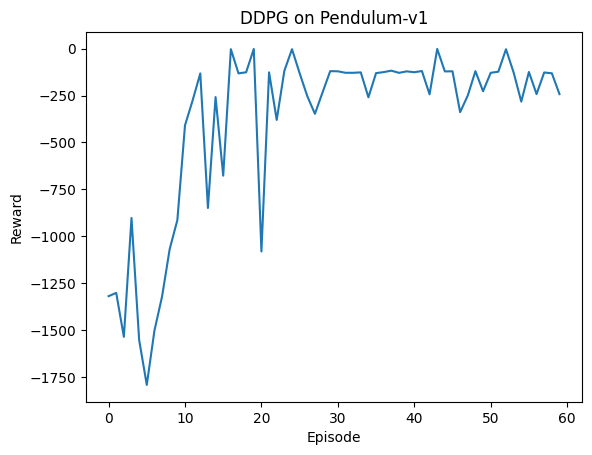

In [7]:
# 2. Plot
plt.plot(history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DDPG on Pendulum-v1")
plt.show()

In [9]:

# 3. Test the TRAINED agent
test_agent('Pendulum-v1', trained_agent)

Test Episode 1: Total Reward = -121.75
Test Episode 2: Total Reward = -123.83
Test Episode 3: Total Reward = -365.74


In [10]:

untrained_agent = DDPGAgent(gym.make('Pendulum-v1'))
test_agent(env_name='Pendulum-v1', agent=untrained_agent)

Test Episode 1: Total Reward = -1073.96
Test Episode 2: Total Reward = -1409.80
Test Episode 3: Total Reward = -1175.29
